In [1]:
!pip install torchcontrib

  Preparing metadata (setup.py) ... done
  Created wheel for torchcontrib: filename=torchcontrib-0.0.2-py3-none-any.whl size=7532 sha256=727d66667bd06453316c6220bd03e16674bb0f78eb903db0c6a3d562b4be3365
  Stored in directory: /root/.cache/pip/wheels/1a/f9/ce/366b12d265606cfc25a1ef924d8f5bd5c0479c13d3582dbbc3
Successfully built torchcontrib


Проверить точность на 5 фолдах для текущей модели
Посмотреть без умных боксов точность

In [2]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchcontrib.optim import SWA

from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import AutoModelForPreTraining, AutoTokenizer, AutoConfig
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from tqdm.autonotebook import tqdm
import utils

In [3]:
# Maximum length of the input vector.
MAX_LEN = 1050
# Batch size of training and validation set.
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 2
# The number of epochs of model training.
EPOCHS = 35
# Name of the BERT model
BERT_PATH = "cointegrated/rubert-tiny2"
# Path to save the trained model.
MODEL_SAVE_PATH = 'model.bin'
# Path to training file.
TRAINING_FILE = '/kaggle/input/kontur2023/nlp_test_task_2023/nlp_test_task_2023/dataset/train.json'
# Tokenizer for ruBERT-tiny2 model.
TOKENIZER = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2", lowercase=True)
# Label regularization.
SOFT_ALPHA = 0.4

In [13]:
def jaccard_array(a, b):
    """Calculates Jaccard on arrays."""
    a = set(a)
    b = set(b)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def process_data(text, extracted_part, idx0, idx1, label, tokenizer, max_len):
    '''Creating arrays with tokens, offsets and masks for the BERT model.
    
    Args:
        text: The original text of the document.
        extracted_part: The original extracted part of the text alias the correct answer.
        idx0: The character index of the end of the correct answer.
        idx1: The character index of the start of the correct answer.
        label: Text labels.
        tokenizer: The tokenizer to use for the BERT model.
        max_len: The length of the longest sentence after tokenization, including special tokens.
        
    Returns:
        dictionary with keys:
            ids: Output ids for the BERT model for the Q&A problem.
            mask: The attention mask
            token_type_ids: The type of input tokens to split the array into "label" aka question and "text".
            targets_start: The token index of the start of the correct answer.
            targets_end: The token index of the end of the correct answer.
            orig_text: The original text.
            orig_extracted: The original extracted part.
            label: The label of the original text.
            offsets: The beginning and end of each word in a sentence.
    '''
    character_targets = [0] * len(text)
    # [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
    if idx0 != 0 and idx1 != 0:
        for ct in range(idx0, idx1 + 1):
            character_targets[ct] = 1
    # [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]
    # Where 1 is the target values, what should be extracted.
    
    # Create tokenizer.
    tok_text = tokenizer.encode_plus(text, return_offsets_mapping=True)
    # Input ids of tokens from input text and delete special tokens ([CLS], [SEP]).
    input_ids_orig = tok_text.input_ids[1:-1]
    # Save offsets of words in the text without tokens.
    text_offsets = tok_text.offset_mapping[1:-1]
    
    # Create targets for words with offset_mapping.
    target_idx = []
    for k, (offset_1, offset_2) in enumerate(text_offsets):
        if sum(character_targets[offset_1: offset_2]) > 0:
            target_idx.append(k)
    
    # Check if there is an answer in the text.
    if len(target_idx) > 0:
        targets_start = target_idx[0]
        targets_end = target_idx[-1]
    else:
        targets_start = 0
        targets_end = 0
    # There are target arrays like:
    # [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] - target start
    # [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] - target end
    
    # ids of tokens for labels of the texts.
    label_id = {
        'обеспечение исполнения контракта': [33231, 32922, 36035],
        'обеспечение гарантийных обязательств': [33231, 55482, 2313, 38970],   
    }
    # Soft targets
    # ------------------
    n = len(input_ids_orig)
    sentence = np.arange(n)
    # Create an array with the correct answer.
    answer = sentence[targets_start:targets_end + 1]
    
    start_labels = np.zeros(n)
    for i in range(targets_end+1):
        jac = jaccard_array(answer, sentence[i:targets_end + 1])
        start_labels[i] = jac + jac**2
    start_labels = (1 - SOFT_ALPHA) * start_labels / start_labels.sum()
    start_labels[targets_start] += SOFT_ALPHA
    
    end_labels = np.zeros(n)
    for i in range(targets_start, n):
        jac = jaccard_array(answer, sentence[targets_start:i + 1])
        end_labels[i] = jac + jac**2
    end_labels = (1 - SOFT_ALPHA) * end_labels / end_labels.sum()
    end_labels[targets_end] += SOFT_ALPHA
    
    # We format the arrays for the Q&A format for BERT:
    # [CLS] label_id [SEP] text [SEP].
    # And, since we added special tokens, we must make the appropriate offsets in all other arrays.
    # We add +5 for 'обеспечение исполнения контракта' label and +6 for 'обеспечение гарантийных обязательств'
    # because their length differs by one token.
    # [CLS] + len(label) + [SEP] = 5 or 6!
    if label == 'обеспечение исполнения контракта':
        input_ids = [2] + [*label_id[label]] + [3] + input_ids_orig + [3]
        token_type_ids = [0, 0, 0, 0, 0] + [1] * (len(input_ids_orig) + 1)
        mask = [1] * len(token_type_ids)
        text_offsets = [(0, 0)] * 5 + text_offsets + [(0, 0)]
        start_labels = [0, 0, 0, 0, 0] + list(start_labels) + [0]
        end_labels = [0, 0, 0, 0, 0] + list(end_labels) + [0]
        targets_start += 5
        targets_end += 5
        orig_start = 5
        orig_end = len(input_ids_orig) + 4
    else:
        input_ids = [2] + [*label_id[label]] + [3] + input_ids_orig + [3]
        token_type_ids = [0, 0, 0, 0, 0, 0] + [1] * (len(input_ids_orig) + 1)
        mask = [1] * len(token_type_ids)
        text_offsets = [(0, 0)] * 6 + text_offsets + [(0, 0)]
        start_labels = [0, 0, 0, 0, 0, 0] + list(start_labels) + [0]
        end_labels = [0, 0, 0, 0, 0, 0] + list(end_labels) + [0]
        targets_start += 6
        targets_end += 6
        orig_start = 6
        orig_end = len(input_ids_orig) + 5
    
    # We adjust the length of the input vectors to the max_len parameter.
    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        text_offsets = text_offsets + ([(0, 0)] * padding_length)
        start_labels = start_labels + ([0] * padding_length)
        end_labels = end_labels + ([0] * padding_length)
        
    return {
        'ids': input_ids,
        'mask': mask,
        'token_type_ids': token_type_ids,
        'targets_start': start_labels,
        'targets_end': end_labels,
        'orig_text': text,
        'orig_extracted': extracted_part,
        'orig_start': orig_start,
        'orig_end': orig_end,
        'label': label,
        'offsets': text_offsets
    }

# LOADING DATA

In [5]:
class TextLoading:
    '''Loading data in the correct form in the model.

    '''
    def __init__(self, text, label, extracted_part, idx0, idx1):
        '''Initializes the values for data preparation.
        
        Args:
            text: The original text of the document.
            label: Text labels.
            extracted_part: The original extracted part of the text alias the correct answer.
            idx0: The character index of the end of the correct answer.
            idx1: The character index of the start of the correct answer.
        '''
        self.text = text
        self.label = label
        self.extracted_part = extracted_part
        self.idx0 = idx0
        self.idx1 = idx1
        self.tokenizer = TOKENIZER
        self.max_len = MAX_LEN
    
    def __len__(self):
        '''Return len of the text
        
        '''
        return len(self.text)
    
    def __getitem__(self, item):
        data = process_data(
            self.text[item], 
            self.extracted_part[item],
            self.idx0[item],
            self.idx1[item],
            self.label[item],
            self.tokenizer,
            self.max_len
        )
        # Return the processed data converted to torch.tensor format.
        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'targets_start': torch.tensor(data["targets_start"], dtype=torch.float),
            'targets_end': torch.tensor(data["targets_end"], dtype=torch.float),
            'orig_text': data["orig_text"],
            'orig_extracted': data["orig_extracted"],
            'orig_start': data['orig_start'],
            'orig_end': data['orig_end'],
            'label': data["label"],
            'offsets': torch.tensor(data["offsets"], dtype=torch.long)
        }

# MODEL

In [6]:
class TextModel(transformers.BertPreTrainedModel):
    def __init__(self, conf):
        super(TextModel, self).__init__(conf)
        # Create backbone of BERT model.
        self.bert = AutoModelForPreTraining.from_pretrained(BERT_PATH, config=conf)
        # Dropout to backbone BERT model with 50% probability.
        self.drop_out_high = nn.Dropout(0.5)
        # Create linear output with size 312 (size of BERT output).
        # Multiplication by 2 is necessary because the last two layers are taken.
        self.classifier = nn.Linear(conf.hidden_size * 2, 2)
        # Initialization of weights for linear layer.
        torch.nn.init.normal_(self.classifier.weight, std=0.02)
    
    def forward(self, ids, mask, token_type_ids):
        '''Direct pass through the NN.
        
        '''
        # Return the hidden states from the BERT model.
        out = self.bert(
                        ids,
                        attention_mask=mask,
                        token_type_ids=token_type_ids
                        )
        
        # Concatenate the last two hidden layers.
        # We take the last two layers, since the last one can be 
        # overfitted on the original training data.
        out = torch.stack(tuple(out.hidden_states[-i -1] for i in range(3)), dim=0)
        out_mean = torch.mean(out, dim=0)
        out_max, _ = torch.max(out, dim=0)
        out = torch.cat((out_mean, out_max), dim=-1)
        logits = torch.mean(torch.stack([self.classifier(self.drop_out_high(out)) for _ in range(5)], dim=0), dim=0)
        
        # Split the vector to start and end logits - start and end of the 
        # correct answer.
        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [7]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    '''Cross entropy loss for start and end logits
    
    '''
    m = torch.nn.LogSoftmax(dim=1)
    loss_fct = torch.nn.KLDivLoss(reduction='batchmean')
    start_loss = loss_fct(m(start_logits), start_positions)
    end_loss = loss_fct(m(end_logits), end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss


# def calculate_jaccard_score(original_text, target_string, 
#                             idx_start, idx_end, offsets):
#     '''Jaccard similarity calculation for original text and prediction.
    
#     Args:
#         original_text: The original text of the document.
#         target_string: Target string (extracted part).
#         idx_start: The predicted index of the start of the string.
#         idx_end: The predicted index of the end of the string.
#         offsets: Offsets of the text after tokenization.
    
#     Returns:
#         jac: The score of jac similarity.
#         filtered_output: The string of the prediction text.
#         idx_start: The predicted index of the start of the string after filtration 
#         (idx_start = 0 if start >= end. It's mean that BERT cannot find the target string).
#         idx_end: The predicted index of the end of the string after filtration.
#     '''
    
#     # If this works, then the model cannot find the target string.
#     # Return 0 for end and start.
#     if idx_end <= idx_start:
#         idx_end = idx_start = 0
    
#     # Return the target string from idx_start/end.
#     filtered_output  = ""
#     for ix in range(idx_start, idx_end + 1):
#         filtered_output += original_text[offsets[ix][0]: offsets[ix][1]]
#         # Add space between words, if token isn't the last one.
#         if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
#             filtered_output += " "
    
#     char_start = offsets[(idx_start)][0]
#     char_end = offsets[(idx_end)][1]
    
#     # Calculate the jaccard score between the predicted text and the original one.
#     jac = utils.jaccard(target_string.strip(), filtered_output.strip())
#     acc = utils.accuracy(target_string.strip(), filtered_output.strip())
#     return jac, filtered_output, char_start, char_end, acc

def best_idx(start_logits, end_logits, orig_start, orig_end):
    best_logit = -np.inf
    best_idxs = None
    start_logits = start_logits[orig_start:orig_end + 1]
    end_logits = end_logits[orig_start:orig_end + 1]
    for start_idx, start_logit in enumerate(start_logits):
        for end_idx, end_logit in enumerate(end_logits[start_idx:]):
            logit_sum = start_logit + end_logit
            if logit_sum > best_logit:
                best_logit = logit_sum
                best_idxs = (orig_start + start_idx, 
                            orig_start + start_idx + end_idx)
    return best_idxs

def calculate_jaccard_score(original_text, target_string, start_logits, end_logits,
                            orig_start, orig_end, offsets):
    
    start_idx, end_idx = best_idx(start_logits, end_logits, orig_start, orig_end)
    
    filtered_output = ''
    for ix in range(start_idx, end_idx + 1):
        filtered_output += original_text[offsets[ix][0]:offsets[ix][1]]
        if (ix + 1) < len(offsets) and offsets[ix][1] < offsets[ix + 1][0]:
            filtered_output += ' '
    char_start = offsets[(start_idx)][0]
    char_end = offsets[(end_idx)][1]
    
    if len(filtered_output.split()) < 4:
        filtered_output = ''
        char_start = char_end = 0
        
    filtered_output = filtered_output.rstrip(' ,/: контракта гарантии')
    
    
    jac = utils.jaccard(target_string.strip(), filtered_output.strip())
    acc = utils.accuracy(target_string.strip(), filtered_output.strip())
    return jac, filtered_output, char_start, char_end, acc

In [8]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):
    '''Training the BERT model.
    
    Args:
        data_loader:
        model:
        optimizer:
        device:
        scheduler:
        
    '''
    # Starting to train the model.
    model.train()
    losses = utils.AverageMeter()
#     jaccards = utils.AverageMeter()
#     accuracy = utils.AverageMeter()
    
    # tqdm to visualize the learning process.
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):
        
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        label = d["label"]
        orig_extracted = d["orig_extracted"]
        orig_text = d["orig_text"]
        orig_start = d['orig_start']
        orig_end = d['orig_end']
        offsets = d["offsets"]
        
        # We transfer the tensors to the device (CPU/GPU)
        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.float)
        targets_end = targets_end.to(device, dtype=torch.float)
        
        # Reset the gradients at the beginning of model training.
        model.zero_grad()
        # Move ids, mask, token_type_ids to the model and 
        # Predict logits start and end values.
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids,
        )
        # Calculate the loss function.
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        # Сalculation gradients from loss function.
        loss.backward()
        # Updating weight parameters
        optimizer.step()
        # Update scheduler => update learning rate
        scheduler.step()
        
        # Applying the softmax function to obtain pseudo probabilities for start and end tokens.
#         outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
#         outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        outputs_start = outputs_start.cpu().detach().numpy()
        outputs_end = outputs_end.cpu().detach().numpy()
        # Jaccard calculation for the epoch.
#         jaccard_scores = []
#         accuracy_scores = []
#         for px, text in enumerate(orig_text):
#             extracted_text = orig_extracted[px]
#             text_label = label[px]
# #             print(orig_start)
#             jaccard_score, _, _, _, accuracy_score = calculate_jaccard_score(
#                                                     original_text=text,
#                                                     target_string=extracted_text,
#                                                     start_logits=outputs_start[px, :],
#                                                     end_logits=outputs_end[px, :],
#                                                     orig_start=orig_start[px],
#                                                     orig_end=orig_end[px],
#                                                     offsets=offsets[px])
            
#             jaccard_scores.append(jaccard_score)
#             accuracy_scores.append(accuracy_score)
        
        # Update losses and jaccard
#         accuracy.update(np.mean(accuracy_scores), ids.size(0))
#         jaccards.update(np.mean(jaccard_scores), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        # tqdm loading bar with updated losses and jaccard at
        # each epoch.
        tk0.set_postfix(loss=losses.avg)#, jaccard=jaccards.avg, accuracy=accuracy.avg)

In [9]:
def eval_fn(data_loader, model, device):
    '''Validation the BERT model.
    
    Args:
        data_loader:
        model:
        optimizer:
        device:
        scheduler:
        
    '''
    # Starting the model validation process: turn off dropout.
    model.eval()
    losses = utils.AverageMeter()
    jaccards = utils.AverageMeter()
    accuracy = utils.AverageMeter()
    
    # Turn off gradient calculation.
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader))
        for bi, d in enumerate(tk0):
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            label = d["label"]
            orig_extracted = d["orig_extracted"]
            orig_text = d["orig_text"]
            orig_start = d['orig_start']
            orig_end = d['orig_end']
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            offsets = d["offsets"].numpy()
            
            # Move tensors to device (CPU/GPU)
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.float)
            targets_end = targets_end.to(device, dtype=torch.float)
            
            # Predict start and the end indexes of the model.
            outputs_start, outputs_end = model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            
            # Calculation loss function.
            loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
            
            # Softmax function for probabilities.
#             outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
#             outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
            outputs_start = outputs_start.cpu().detach().numpy()
            outputs_end = outputs_end.cpu().detach().numpy()
            # Jaccard score calculation.
            jaccard_scores = []
            accuracy_scores = []
            for px, text in enumerate(orig_text):
                extracted_text = orig_extracted[px]
                text_label = label[px]
                jaccard_score, _, _, _, accuracy_score = calculate_jaccard_score(
                                                        original_text=text,
                                                        target_string=extracted_text,
                                                        start_logits=outputs_start[px, :],
                                                        end_logits=outputs_end[px, :],
                                                        orig_start=orig_start[px],
                                                        orig_end=orig_end[px],
                                                        offsets=offsets[px])
                jaccard_scores.append(jaccard_score)
                accuracy_scores.append(accuracy_score)
            
            # Update jaccard and losses.
            accuracy.update(np.mean(accuracy_scores), ids.size(0))
            jaccards.update(np.mean(jaccard_scores), ids.size(0))
            losses.update(loss.item(), ids.size(0))
            # Display scores.
            tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg, accuracy=accuracy.avg)
    
#     print(f"Jaccard = {jaccards.avg}", f"Accuracy = {accuracy.avg}")
    return jaccards.avg, accuracy.avg

In [10]:
def run(fold):
    
    # Read the training file and get it ready to go.
    dfx = pd.read_json(TRAINING_FILE)
    splitted_df = pd.json_normalize(dfx.extracted_part)
    splitted_df['extracted_part'] = splitted_df['text']
    for i in ['extracted_part', 'answer_start', 'answer_end']:
        dfx[i] = splitted_df[i].str[0]
    # Add column with kfold for cross validation.
    dfx['kfold'] = -1

    # Since the objective function is two peaks at zero and around a certain value.
    # Therefore, it is necessary to correctly divide the data set into equal groups:
    # train and valid which contain samples from these two clusters in approximately 
    # the same amount. This makes it possible not to overfit the model only on the 
    # sample with answer start = 0, or another group of samples.

    dfx_temp = dfx.loc[dfx['answer_start'] != 0]
    dfx['q_answer_start'] = pd.qcut(dfx_temp['answer_start'], q=2).astype('str')
    dfx['q_answer_start'] = dfx['q_answer_start'].replace(np.nan, 0).astype('str')
    dfx['q_answer_start_label'] = dfx.q_answer_start.str.cat(dfx.label)
    kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    y = dfx["q_answer_start_label"].values
    
    # Create 5 folders for 5 models. In the future, we will average the output values
    # across all models, which in theory will give a better result than if we trained 
    # a single model.
    for kfold, (train_idx, valid_idx) in enumerate(kf.split(X=dfx, y=y)):
        dfx.loc[valid_idx, "kfold"] = kfold

    # create fold from dfx 0,1,2,3,4.
    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
    
    # Create train dataset from TextLoading.
    train_dataset = TextLoading(
        text=df_train.text.values,
        label=df_train.label.values,
        extracted_part=df_train.extracted_part.values,
        idx0=df_train.answer_start.values,
        idx1=df_train.answer_end.values
    )
    
    # Creating a generator to give out a data set in batches.
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TRAIN_BATCH_SIZE,
        num_workers=2
    )
    
    # Create valid dataset from TextLoading.
    valid_dataset = TextLoading(
        text=df_valid.text.values,
        label=df_valid.label.values,
        extracted_part=df_valid.extracted_part.values,
        idx0=df_valid.answer_start.values,
        idx1=df_valid.answer_end.values
    )
    
    # Creating a generator to give out a data set in batches.
    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size=VALID_BATCH_SIZE,
        num_workers=1
    )

    # Turn on GPU for calculation gradients.
    device = torch.device("cuda")
    # Loading pretrained BERT model.
    model_config = AutoConfig.from_pretrained(BERT_PATH)
    # Output hidden states ON for concatenate the hidden states
    # from the last 2 layers of BERT.
    model_config.output_hidden_states = True
    model = TextModel(conf=model_config)
    # Move the model to the GPU.
    model.to(device)

    # Calculation the number of training steps.
    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    # Get model parameters.
    param_optimizer = list(model.named_parameters())
    # Parameters that we don't won't to change.
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    # Creat two sets of parameters with weight decay = 0 and 
    # with weight decay =/= 0 for update it
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    # Create AdamW optimizer with our parameters.
    base_opt = transformers.AdamW(optimizer_parameters, lr=7e-5, no_deprecation_warning=True)
    optimizer = SWA(base_opt, swa_start=int(num_train_steps * 0.9),
                                       swa_freq=30, swa_lr=None)
    
    # Creating a schedule to control the learning rate during training. 
    # This schedule have got a learning rate that decreases linearly at each training step.
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=int(num_train_steps * 0.25), 
        num_training_steps=num_train_steps
    )
    
    # Create early stopping function with patience = 6. 
    # This means that the learning process will stop after two unsuccessful epochs.
    es = utils.EarlyStopping(patience=5, mode="max")
    print(f"Training is Starting for fold={fold}")
    
    # Training the model.
    for epoch in range(EPOCHS):
        train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
        jaccard, accuracy = eval_fn(valid_data_loader, model, device)
        print(f"Accuracy score = {accuracy}", f"\nJaccard Score = {jaccard}")
        es(jaccard, model, model_path=f"model_{fold}.bin")
        if es.early_stop:
            print("Early stopping")
            break
    return jaccard

In [11]:
jaccard = []

In [14]:
jaccard.append(run(fold=0))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Training is Starting for fold=0


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.08888888888888889 
Jaccard Score = 0.22087417958552327
Validation score improved (-inf --> 0.22087417958552327). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.21666666666666667 
Jaccard Score = 0.2324333257621158
Validation score improved (0.22087417958552327 --> 0.2324333257621158). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.5333333333333333 
Jaccard Score = 0.7184620526744124
Validation score improved (0.2324333257621158 --> 0.7184620526744124). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.5694444444444444 
Jaccard Score = 0.7715963246438654
Validation score improved (0.7184620526744124 --> 0.7715963246438654). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6333333333333333 
Jaccard Score = 0.8259570729739684
Validation score improved (0.7715963246438654 --> 0.8259570729739684). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6611111111111111 
Jaccard Score = 0.8413696630439217
Validation score improved (0.8259570729739684 --> 0.8413696630439217). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6805555555555556 
Jaccard Score = 0.8683196300852689
Validation score improved (0.8413696630439217 --> 0.8683196300852689). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6833333333333333 
Jaccard Score = 0.8862966111507098
Validation score improved (0.8683196300852689 --> 0.8862966111507098). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6888888888888889 
Jaccard Score = 0.8886711599840836
Validation score improved (0.8862966111507098 --> 0.8886711599840836). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.6944444444444444 
Jaccard Score = 0.8946368936320721
Validation score improved (0.8886711599840836 --> 0.8946368936320721). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7 
Jaccard Score = 0.9002826383469723
Validation score improved (0.8946368936320721 --> 0.9002826383469723). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7055555555555556 
Jaccard Score = 0.9005441834900918
EarlyStopping counter: 1 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7166666666666667 
Jaccard Score = 0.9072170574651923
Validation score improved (0.9002826383469723 --> 0.9072170574651923). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7111111111111111 
Jaccard Score = 0.9056823834837993
EarlyStopping counter: 1 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7083333333333334 
Jaccard Score = 0.9114706165681483
Validation score improved (0.9072170574651923 --> 0.9114706165681483). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7166666666666667 
Jaccard Score = 0.9090093821097075
EarlyStopping counter: 1 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7138888888888889 
Jaccard Score = 0.9160092782648085
Validation score improved (0.9114706165681483 --> 0.9160092782648085). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7194444444444444 
Jaccard Score = 0.9234218052525409
Validation score improved (0.9160092782648085 --> 0.9234218052525409). Saving model!


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7111111111111111 
Jaccard Score = 0.9119654104927222
EarlyStopping counter: 1 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7111111111111111 
Jaccard Score = 0.9186891638757433
EarlyStopping counter: 2 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7138888888888889 
Jaccard Score = 0.9203134031460625
EarlyStopping counter: 3 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.7166666666666667 
Jaccard Score = 0.9225807814673217
EarlyStopping counter: 4 out of 5


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/180 [00:00<?, ?it/s]

Accuracy score = 0.725 
Jaccard Score = 0.9214272824687854
EarlyStopping counter: 5 out of 5
Early stopping


0.764 - lr=6 <br>
0.769 - lr=7 <br>
alpha = 0.6, +6,+5 - 0.766 <br>
alpha = 0.5, +5,+4 - 0.752

In [ ]:
jaccard.append(run(fold=1))

In [ ]:
jaccard.append(run(fold=2))

In [ ]:
jaccard.append(run(fold=3))

In [ ]:
jaccard.append(run(fold=4))

In [ ]:
sum(jaccard) / len(jaccard)

In [16]:
device = torch.device("cuda")
model_config = AutoConfig.from_pretrained(BERT_PATH)
model_config.output_hidden_states = True

In [17]:
model1 = TextModel(conf=model_config)
model1.to(device)
model1.load_state_dict(torch.load("/kaggle/working/model_0.bin"))
model1.eval()

# model2 = TextModel(conf=model_config)
# model2.to(device)
# model2.load_state_dict(torch.load("/kaggle/working/model_1.bin"))
# model2.eval()

# model3 = TextModel(conf=model_config)
# model3.to(device)
# model3.load_state_dict(torch.load("/kaggle/working/model_2.bin"))
# model3.eval()

# model4 = TextModel(conf=model_config)
# model4.to(device)
# model4.load_state_dict(torch.load("/kaggle/working/model_3.bin"))
# model4.eval()

# model5 = TextModel(conf=model_config)
# model5.to(device)
# model5.load_state_dict(torch.load("/kaggle/working/model_4.bin"))
# model5.eval()

TextModel(
  (bert): BertForPreTraining(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(83828, 312, padding_idx=0)
        (position_embeddings): Embedding(2048, 312)
        (token_type_embeddings): Embedding(2, 312)
        (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=312, out_features=312, bias=True)
                (key): Linear(in_features=312, out_features=312, bias=True)
                (value): Linear(in_features=312, out_features=312, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=312, out_features=312, bias=True)
            

In [25]:
dfx_test = pd.read_json('/kaggle/input/kontur2023/nlp_test_task_2023/nlp_test_task_2023/dataset/test.json')
dfx_test.loc[:, 'extracted_part'] = dfx_test.text.values
dfx_test.loc[:, 'answer_start'] = 0
dfx_test.loc[:, 'answer_end'] = dfx_test.text.str.len() 

In [19]:
# Read the training file and get it ready to go.
dfx_test = pd.read_json(TRAINING_FILE)
splitted_df = pd.json_normalize(dfx_test.extracted_part)
splitted_df['extracted_part'] = splitted_df['text']
for i in ['extracted_part', 'answer_start', 'answer_end']:
    dfx_test[i] = splitted_df[i].str[0]
dfx_test['answer_start_train'] = dfx_test['answer_start']
dfx_test['answer_end_train'] = dfx_test['answer_end']
# Add column with kfold for cross validation.
dfx_test.loc[:, 'extracted_part'] = dfx_test.text.values
dfx_test.loc[:, 'answer_start'] = 0
dfx_test.loc[:, 'answer_end'] = dfx_test.text.str.len()
dfx_test

,id,text,label,extracted_part,answer_start,answer_end,answer_start_train,answer_end_train
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Извещение о проведении открытого конкурса в эл...,0,2594,1279,1343
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,0,2420,1222,1318
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,0,2492,1297,1343
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,0,2644,1304,1350
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Извещение о проведении электронного аукциона д...,0,2652,1302,1348
...,...,...,...,...,...,...,...,...
1794,938335285,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________...",обеспечение гарантийных обязательств,"«УТВЕРЖДАЮ» Директор МУП ""ПКП и ОРТ"" _________...",0,2625,1213,1402
1795,214609521,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,обеспечение гарантийных обязательств,ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯ...,0,1138,0,0
1796,94811748,ДОГОВОР ПОДРЯДА № _____ «___»___________20____...,обеспечение гарантийных обязательств,ДОГОВОР ПОДРЯДА № _____ «___»___________20____...,0,1259,0,0
1797,903507299,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...,обеспечение гарантийных обязательств,ДОКУМЕНТАЦИЯ О ЗАКУПКЕ ЗАПРОС ПРЕДЛОЖЕНИЙ В ЭЛ...,0,1003,0,0


In [20]:
final_output = []

test_dataset = TextLoading(
        text=dfx_test.text.values,
        label=dfx_test.label.values,
        extracted_part=dfx_test.extracted_part.values,
        idx0=dfx_test.answer_start.values,
        idx1=dfx_test.answer_end.values
    )

data_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=4,
    num_workers=1
)

with torch.no_grad():
    tk0 = tqdm(data_loader, total=len(data_loader))
    for bi, d in enumerate(tk0):
        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        label = d["label"]
        orig_extracted = d["orig_extracted"]
        orig_text = d["orig_text"]
        orig_start = d['orig_start']
        orig_end = d['orig_end']
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"].numpy()

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.float)
        targets_end = targets_end.to(device, dtype=torch.float)

        outputs_start1, outputs_end1 = model1(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids
        )
        
#         outputs_start2, outputs_end2 = model2(
#             ids=ids,
#             mask=mask,
#             token_type_ids=token_type_ids
#         )
        
#         outputs_start3, outputs_end3 = model3(
#             ids=ids,
#             mask=mask,
#             token_type_ids=token_type_ids
#         )
        
#         outputs_start4, outputs_end4 = model4(
#             ids=ids,
#             mask=mask,
#             token_type_ids=token_type_ids
#         )
        
#         outputs_start5, outputs_end5 = model5(
#             ids=ids,
#             mask=mask,
#             token_type_ids=token_type_ids
#         )
        outputs_start = (
            outputs_start1 )
#             + outputs_start2 
#             + outputs_start3 
#             + outputs_start4 
#             + outputs_start5
#         ) / 5
        outputs_end = (
            outputs_end1 )
#             + outputs_end2 
#             + outputs_end3 
#             + outputs_end4 
#             + outputs_end5
#         ) / 5
        
#         outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
#         outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        outputs_start = outputs_start.cpu().detach().numpy()
        outputs_end = outputs_end.cpu().detach().numpy()
                
        for px, text in enumerate(orig_text):
            extracted_text = orig_extracted[px]
            text_label = label[px]
            _, output_sentence, ind_start, ind_end, _ = calculate_jaccard_score(
                original_text=text,
                target_string=extracted_text,
                start_logits=outputs_start[px, :],
                end_logits=outputs_end[px, :],
                orig_start=orig_start[px],
                orig_end=orig_end[px],
                offsets=offsets[px])
            
            final_output.append([output_sentence, ind_start, ind_end])

  0%|          | 0/450 [00:00<?, ?it/s]

In [ ]:
dfx_test[['extracted_path', 'answer_start', 'answer_end']] = final_output
sample_submission = pd.DataFrame()
sample_submission[['id', 'text_full', 'label', 'text', 'answer_start', 'answer_end']] = dfx_test[['id', 'text', 'label', 'extracted_path', 
                                                                                                  'answer_start', 'answer_end']]
# sample_submission['dif'] = sample_submission['answer_start'] - sample_submission['answer_start_train']
# sample_submission.to_csv('Baseline.csv', index=False, encoding='utf-8-sig')
# sample_submission.head(3)

In [21]:
dfx_test[['extracted_path', 'answer_start', 'answer_end']] = final_output
sample_submission = pd.DataFrame()
sample_submission[['id', 'text_full', 'label', 'text', 'answer_start', 'answer_end', 'answer_start_train', 'answer_end_train']] = dfx_test[['id', 'text', 'label', 
                                                                                                                                            'extracted_path', 'answer_start', 'answer_end', 'answer_start_train', 
                                                                                                                                            'answer_end_train']]
sample_submission['dif_start'] = sample_submission['answer_start'] - sample_submission['answer_start_train']
sample_submission['dif_end'] = sample_submission['answer_end'] - sample_submission['answer_end_train']
# sample_submission.to_csv('Baseline.csv', index=False, encoding='utf-8-sig')
sample_submission.head(3)

,id,text_full,label,text,answer_start,answer_end,answer_start_train,answer_end_train,dif_start,dif_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 6593.2...,1279,1343,1279,1343,0,0
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,Поставщик должен предоставить обеспечение испо...,1222,1318,1222,1318,0,0
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,Размер обеспечения исполнения контракта 10.00%,1297,1343,1297,1343,0,0


In [198]:
num = 130
print(sample_submission.text_full[num])
print('\n', sample_submission.label[num])
# print('\n', sample_submission.text[num].rstrip(' ,/:контрактагарантии'))
print('\n', sample_submission.text[num])

1 Приложение № 4 к Извещению об электронном аукционе Контракт № _____ на поставку продуктов питания (Идентификационный код закупки - 221525400211352540100100950171051244) г. Саров, Нижегородской обл. «__» __________2022 г. Федеральное государственное , предусмотренных пунктом 5.5 Контракта, а также документов на оплату: а) счета; б) счета-фактуры (при наличии). 8.5. На всех документах, указанных в пункте 8.4 Контракта, должны быть указаны наименование Заказчика, Поставщика, номер и дата Контракта, даты оформления и подписания документов. 8.6. Оплата по Контракту осуществляется по факту поставки Товара на основании Заявки на поставку Товара (Приложение № 2 к Контракту) в срок не позднее 7 рабочих дней с даты подписания Заказчиком документа о приемке в единой информационной системе, и на основании документов, предусмотренных пунктом 8.4 Контракта. 8.7. После оплаты Заказчиком всего поставленного Товара по Контракту Поставщик в течение 5 рабочих дней представляет Заказчику Акт сверки расч

In [23]:
pd.set_option('display.max_rows', 1000)
test = sample_submission[sample_submission['dif_end'] !=0 ]
len(test)
# test.head(1000)

332

In [24]:
pd.set_option('display.max_rows', 1000)
test = sample_submission[sample_submission['dif_start'] !=0 ]
# test.head(1000)
len(test)

27

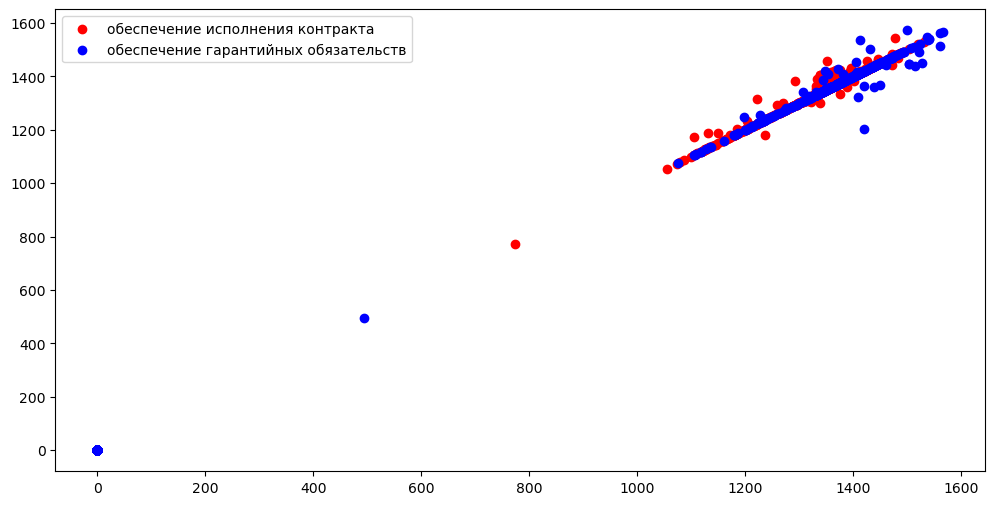

In [25]:
import matplotlib.pyplot as plt
label_1 = dfx_test[dfx_test['label']=='обеспечение исполнения контракта']
label_2 = dfx_test[dfx_test['label']=='обеспечение гарантийных обязательств']

plt.figure(figsize=(12,6))
plt.scatter(label_1['answer_end_train'], label_1['answer_end'], c='red', label='обеспечение исполнения контракта')
plt.scatter(label_2['answer_end_train'], label_2['answer_end'], c='blue', label='обеспечение гарантийных обязательств')
plt.legend()
plt.show()

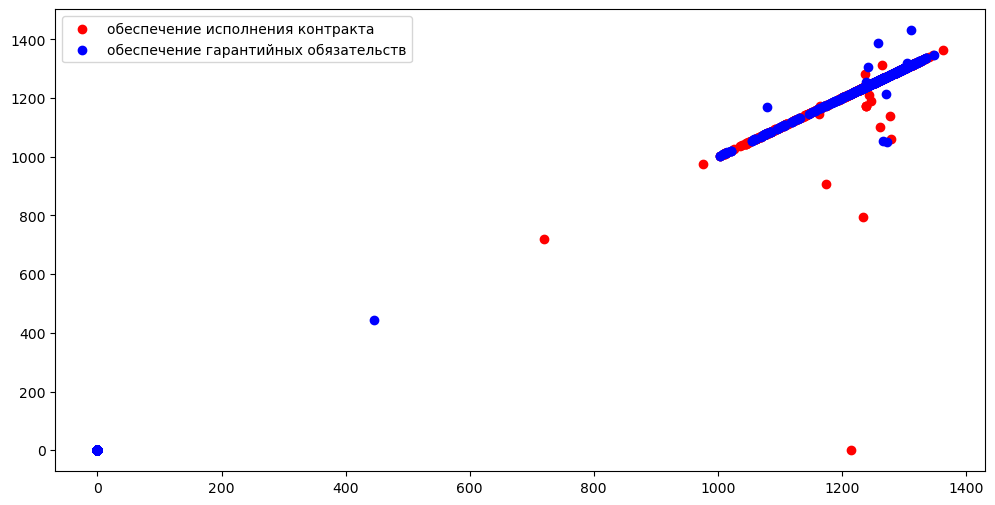

In [26]:
import matplotlib.pyplot as plt
label_1 = dfx_test[dfx_test['label']=='обеспечение исполнения контракта']
label_2 = dfx_test[dfx_test['label']=='обеспечение гарантийных обязательств']

plt.figure(figsize=(12,6))
plt.scatter(label_1['answer_start_train'], label_1['answer_start'], c='red', label='обеспечение исполнения контракта')
plt.scatter(label_2['answer_start_train'], label_2['answer_start'], c='blue', label='обеспечение гарантийных обязательств')
plt.legend()
plt.show()

In [ ]:
text_bracket, answer_start_bracket, answer_end_bracket = [], [], []

for index, row in sample_submission.iterrows():
    text_bracket.append([row.text])
    answer_start_bracket.append([row.answer_start])
    answer_end_bracket.append([row.answer_end])
sample_submission['text'] = text_bracket
sample_submission['answer_start'] = answer_start_bracket
sample_submission['answer_end'] = answer_end_bracket

simple_json = pd.DataFrame()
simple_json['id'] = sample_submission['id']
simple_json['text'] = sample_submission['text_full']
simple_json['label'] = sample_submission.label
simple_json['extracted_part'] = sample_submission[['text', 'answer_start', 'answer_end']].to_dict(orient='records')
simple_json.to_json('predictions.json', orient='records', force_ascii=False)